# Data Exploration Exercises
---

In [1]:
# imports
import pyspark
from pyspark.sql.functions import *

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# wrangle data
spark = pyspark.sql.SparkSession.builder.getOrCreate()
# read csv data into spark dataframes
case = spark.read.csv('case.csv', header=True, inferSchema=True)
dept = spark.read.csv('dept.csv', header=True, inferSchema=True)
source = spark.read.csv('source.csv', header=True, inferSchema=True)
case = case.withColumnRenamed('SLA_due_date', 'case_due_date')
# convert datatypes to time
case = (
    case.withColumn('case_opened_date', to_timestamp(col('case_opened_date'), 'M/d/yy H:mm'))
    .withColumn('case_closed_date', to_timestamp(col('case_closed_date'), 'M/d/yy H:mm'))
    .withColumn('case_due_date', to_timestamp(col('case_due_date'), 'M/d/yy H:mm'))
)
# make boolean
case = (
    case.withColumn('case_late', col('case_late') == 'YES')
    .withColumn('case_closed', col('case_closed') == 'YES')
)
# convert to string
case = case.withColumn('council_district', format_string('%04d', col('council_district')))
# join dataframes
df = case.join(dept, 'dept_division', 'left').join(source, 'source_id', 'left')
df.show(1, False, True)

-RECORD 0------------------------------------------------------
 source_id              | svcCRMLS                             
 dept_division          | Field Operations                     
 case_id                | 1014127332                           
 case_opened_date       | 2018-01-01 00:42:00                  
 case_closed_date       | 2018-01-01 12:29:00                  
 case_due_date          | 2020-09-26 00:42:00                  
 case_late              | false                                
 num_days_late          | -998.5087616000001                   
 case_closed            | true                                 
 service_request_type   | Stray Animal                         
 SLA_days               | 999.0                                
 case_status            | Closed                               
 request_address        | 2315  EL PASO ST, San Antonio, 78207 
 council_district       | 0005                                 
 dept_name              | Animal Care Se

### 1. How many different cases are there, by department?

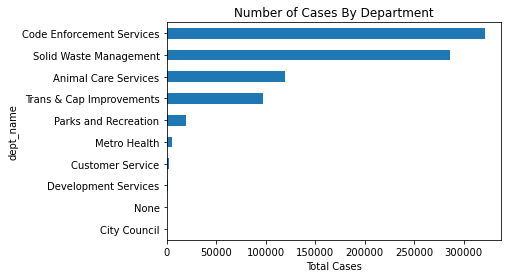

In [6]:
df.groupby("dept_name")\
.count()\
.toPandas()\
.set_index("dept_name")["count"]\
.sort_values()\
.plot.barh()\

plt.gca().set(xlabel="Total Cases", title="Number of Cases By Department");

### 2. Does the percentage of cases that are late vary by department?

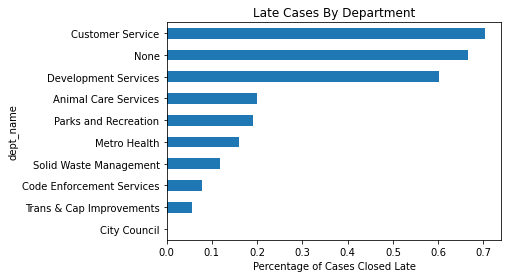

In [11]:
df.withColumn("case_late", col("case_late").cast("int"))\
.groupby("dept_name")\
.agg(avg("case_late").alias("pct_cases_late"))\
.toPandas()\
.set_index("dept_name")\
.pct_cases_late.sort_values()\
.plot.barh()

plt.gca().set(xlabel="Percentage of Cases Closed Late", title="Late Cases By Department");

### 3. On average, how late are the late cases by department?

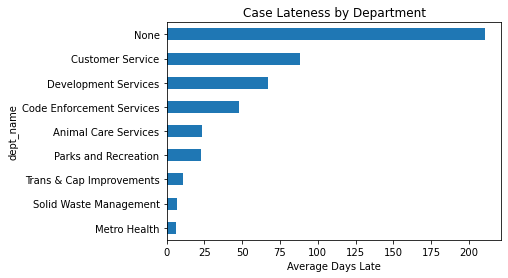

In [12]:
df.filter("case_late")\
.groupby("dept_name")\
.agg(avg("num_days_late").alias("avg_days_late"))\
.toPandas()\
.set_index("dept_name")\
.avg_days_late.sort_values()\
.plot.barh()\
.set(xlabel="Average Days Late", title="Case Lateness by Department");

### 4. What is the service type that is the most late? Just for Parks & Rec?

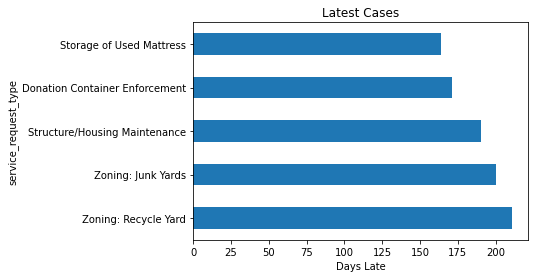

In [4]:
df.filter(df.case_late)\
.groupby("service_request_type")\
.agg(mean("num_days_late").alias("avg_days_late"))\
.sort(desc("avg_days_late"))\
.limit(5)\
.toPandas()\
.set_index("service_request_type")\
.avg_days_late\
.plot.barh()\
.set(title="Latest Cases", xlabel="Days Late");

### 5. For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

[Text(0.5, 0, 'Number of Requests'),
 Text(0.5, 1.0, 'Most Common Code Enforcement Service Request Types')]

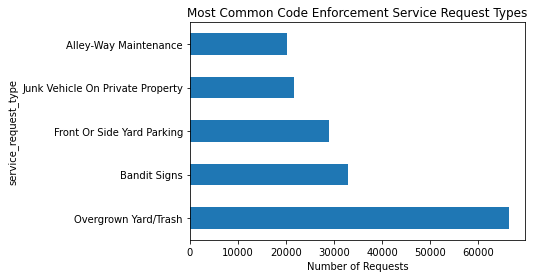

In [21]:
df.filter(df.dept_name == "Code Enforcement Services")\
.groupby("service_request_type")\
.count()\
.sort(desc("count"))\
.limit(5)\
.toPandas()\
.set_index("service_request_type")["count"]\
.plot.barh()\
.set(xlabel="Number of Requests", title="Most Common Code Enforcement Service Request Types")

### 6. Does whether or not its a weekend matter for when a case is opened/closed?

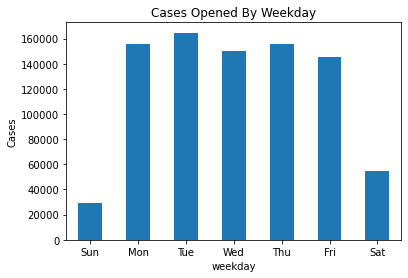

In [7]:
days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']

(
    df.withColumn("weekday", date_format("case_opened_date", "E"))
    .groupby("weekday")
    .count()
    .na.drop()
    .toPandas()
    .assign(weekday=lambda df: pd.Categorical(df.weekday, categories=days, ordered=True))
    .set_index("weekday")["count"]
    .sort_index()
    .plot.bar().set(ylabel="Cases", title="Cases Opened By Weekday")
)
plt.xticks(rotation=0);

### 7. On average, how many cases are opened a day for the Customer Service department?

In [9]:
df.withColumn("case_opened_date", expr("date(case_opened_date)"))\
.filter(df.dept_name == "Customer Service")\
.groupby("case_opened_date")\
.count()\
.toPandas()\
['count'].mean()

5.642578125